In [1]:
import pandas as pd
import numpy as np
import patsy
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import quandl
quandl.ApiConfig.api_key = "K2_QhN367bave427b6xY"

In [3]:
# Apple stock
df = quandl.get("WIKI/" + 'AAPL', start_date="2014-01-01")
df

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,555.68,557.03,552.021,553.1300,8381600.0,0.0,1.0,73.862376,74.041821,73.376012,73.523423,58671200.0
2014-01-03,552.86,553.70,540.430,540.9800,14016700.0,0.0,1.0,73.487534,73.599189,71.835308,71.908415,98116900.0
2014-01-06,537.45,546.80,533.600,543.9300,14736100.0,0.0,1.0,71.439198,72.682024,70.927447,72.300536,103152700.0
2014-01-07,544.32,545.96,537.925,540.0375,11328900.0,0.0,1.0,72.352376,72.570369,71.502337,71.783135,79302300.0
2014-01-08,538.81,545.56,538.690,543.4600,9233200.0,0.0,1.0,71.619973,72.517200,71.604022,72.238063,64632400.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,175.04,175.09,171.260,171.2700,35247358.0,0.0,1.0,175.040000,175.090000,171.260000,171.270000,35247358.0
2018-03-22,170.00,172.68,168.600,168.8450,41051076.0,0.0,1.0,170.000000,172.680000,168.600000,168.845000,41051076.0
2018-03-23,168.39,169.92,164.940,164.9400,40248954.0,0.0,1.0,168.390000,169.920000,164.940000,164.940000,40248954.0


In [4]:
len(df)
df['Split Ratio'].value_counts()
df[df['Split Ratio'] == 7.0] # date when stock split of 7 occured

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-06-09,92.7,93.88,91.75,93.7,75414997.0,0.0,7.0,87.252203,88.362857,86.358033,88.193435,75414997.0


In [5]:
# Let’s pull only stock prices after that date to keep things simple:
aapl_split = quandl.get("WIKI/" + 'AAPL', start_date="2014-06-10")
aapl_split.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-06-10,94.73,95.05,93.57,94.25,62777000.0,0.0,1.0,89.162904,89.464098,88.071075,88.711112,62777000.0
2014-06-11,94.13,94.76,93.47,93.86,45681000.0,0.0,1.0,88.598165,89.191141,87.976952,88.344032,45681000.0
2014-06-12,94.04,94.12,91.90,92.29,54749000.0,0.0,1.0,88.513454,88.588752,86.499217,86.866298,54749000.0
2014-06-13,92.20,92.44,90.88,91.28,54525000.0,0.0,1.0,86.781587,87.007483,85.539161,85.915654,54525000.0
2014-06-16,91.51,92.75,91.45,92.20,35561000.0,0.0,1.0,86.132137,87.299265,86.075663,86.781587,35561000.0


# Key statistics

1) Check presence of unit root (https://www.statisticshowto.datasciencecentral.com/unit-root/) using Augmented Dickey-Fuller test (similar to t test)


In [6]:
# run ADF to determine unit root
import statsmodels.tsa.stattools as ts
cadf = ts.adfuller(aapl_split.Close)
print('Augmented Dickey Fuller:')
print('Test Statistic =',cadf[0])
print('p-value =',cadf[1])
print('Critical Values =',cadf[4])

Augmented Dickey Fuller:
Test Statistic = -0.7311949821756538
p-value = 0.8385030452760827
Critical Values = {'1%': -3.43722314744835, '5%': -2.8645743628401763, '10%': -2.5683856650361054}


Presence of a unit root implies there’s an underlying trend (non stationarity) that’s driving AAPL, and therefore a pattern we can extract and use for prediction.
We compare the test statistic above with the critical values; if it’s lower than our chosen threshold, we reject the null hypothesis that there is a unit root. As you can see with our large p-value, we must accept the null: there is a unit root for AAPL. This is a good thing, as we can utilize the underlying trends and patterns for prediction.


2) Check Correlation with other Equities

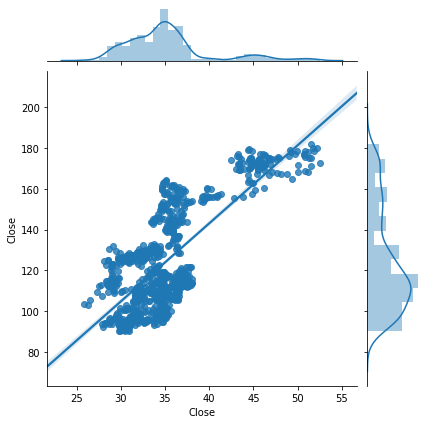

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
MSFT = quandl.get("WIKI/" + 'MSFT', start_date="2014-06-10")
INTC = quandl.get("WIKI/" + 'INTC', start_date="2014-06-10")
TIF = quandl.get("WIKI/" + 'TIF', start_date="2014-06-10")

# Comparing with Intel
sns.jointplot(INTC.Close, aapl_split.Close, kind="reg");

In [8]:
np.corrcoef(INTC.Close, aapl_split.Close)

array([[1.        , 0.74339986],
       [0.74339986, 1.        ]])

r-value of 0.7434; not bad for prediction

let’s check to see correlation with INTC’s closing price seven days in advance for a more viable metric by taking into account time lag of response

In [9]:
# seven day lead
np.corrcoef(INTC.Close[:-7], aapl_split.Close[7:])

array([[1.        , 0.73320604],
       [0.73320604, 1.        ]])

we note an r-value of 0.7332; still pretty good!